#  Problematic Reports Regarding Errors

---

>You will know how to answer the following questions at the end of this notebook.
>- [x] What is a problematic report regarding errors?

In [1]:
import pandas as pd

#### Loading the active reports dataset

In [2]:
active_reports = pd.read_csv("../../datasets/active_reports.csv")

C:\Users\gabim\AppData\Local\Temp\ipykernel_21892\2041366086.py:1: DtypeWarning: Columns (10,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  active_reports = pd.read_csv("../../datasets/active_reports.csv")


#### Loading the Lightning Error dataset

In [3]:
lightning_error = pd.read_csv("../../data/lightning sample/lightning error sample/2022-06-06_LightningError.csv")

In [4]:
lightning_error.columns

Index(['EVENT_TYPE', 'TIMESTAMP', 'REQUEST_ID', 'ORGANIZATION_ID', 'USER_ID',
       'CLIENT_ID', 'SESSION_KEY', 'LOGIN_KEY', 'USER_TYPE', 'APP_NAME',
       'DEVICE_PLATFORM', 'SDK_APP_VERSION', 'OS_NAME', 'OS_VERSION',
       'USER_AGENT', 'BROWSER_NAME', 'BROWSER_VERSION', 'SDK_VERSION',
       'DEVICE_MODEL', 'DEVICE_ID', 'SDK_APP_TYPE', 'CLIENT_GEO',
       'CONNECTION_TYPE', 'UI_EVENT_ID', 'UI_EVENT_TYPE', 'UI_EVENT_SOURCE',
       'UI_EVENT_TIMESTAMP', 'PAGE_START_TIME', 'DEVICE_SESSION_ID',
       'UI_EVENT_SEQUENCE_NUM', 'PAGE_ENTITY_ID', 'PAGE_ENTITY_TYPE',
       'PAGE_CONTEXT', 'PAGE_URL', 'PAGE_APP_NAME', 'COMPONENT_NAME',
       'TIMESTAMP_DERIVED', 'USER_ID_DERIVED', 'CLIENT_IP'],
      dtype='object')

These are the columns the Lightning Error event has, but for this analysis we are interested in some variables like client region, page url, timestamp, etc. So we will filter the dataframes to have only these informations.

In [5]:
error_cols = ['CLIENT_GEO', 'PAGE_URL', 'PAGE_CONTEXT', 'PAGE_ENTITY_TYPE', 'TIMESTAMP', 'TIMESTAMP_DERIVED', 'UI_EVENT_SOURCE', 'UI_EVENT_TYPE', 'USER_AGENT']
report_obj_cols = ['Id', 'Name']

In [6]:
ltng_error = lightning_error[error_cols]
report_names = active_reports[report_obj_cols]

Removing missing data.

In [7]:
ltng_error_cleaned = ltng_error.dropna(subset=error_cols)

We can get the Report ID from the PAGE_URL on Lightning Error, so we filter the endpoints and create a new column called REPORT_ID_DERIVED to save the Report ID on Lightning Error dataframe.

In [8]:
import re

pattern = re.compile(r'\/lightning\/r\/(?P<report_type>[a-zA-Z]{4,})\/(?P<report_id>[0-9a-zA-Z]{18})')

def filter_run_report_endpoints(pattern, url):
    m = re.match(pattern, url)
    if m:
        return m.group('report_id')

In [9]:
ltng_error_cleaned['REPORT_ID_DERIVED'] =\
    ltng_error_cleaned.PAGE_URL.apply(lambda url: filter_run_report_endpoints(pattern, url))

C:\Users\gabim\AppData\Local\Temp\ipykernel_21892\3101863790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltng_error_cleaned['REPORT_ID_DERIVED'] =\


In [10]:
ltng_error_filtered = ltng_error_cleaned.dropna(subset=['REPORT_ID_DERIVED'])

In [11]:
ltng_error_filtered.head()

,CLIENT_GEO,PAGE_URL,PAGE_CONTEXT,PAGE_ENTITY_TYPE,TIMESTAMP,TIMESTAMP_DERIVED,UI_EVENT_SOURCE,UI_EVENT_TYPE,USER_AGENT,REPORT_ID_DERIVED
0,Australia/New South Wales,/lightning/r/Case/5006P000005FoO5QAK/view,one:recordHomeFlexipage2Wrapper,Case,2.022061e+13,2022-06-06T00:00:29.202Z,Error,error,"""Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...",5006P000005FoO5QAK
7,China/Fujian,/lightning/r/Case/5006P000005etR4QAI/view,one:recordHomeFlexipage2Wrapper,Case,2.022061e+13,2022-06-06T00:11:43.243Z,TypeError,error,"""Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...",5006P000005etR4QAI
8,China/Fujian,/lightning/r/Case/5006P000005ermFQAQ/view,one:recordHomeFlexipage2Wrapper,Case,2.022061e+13,2022-06-06T00:12:14.286Z,TypeError,error,"""Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...",5006P000005ermFQAQ
9,China/Fujian,/lightning/r/Case/5006P000005PECNQA4/view,one:recordHomeFlexipage2Wrapper,Case,2.022061e+13,2022-06-06T00:12:52.188Z,TypeError,error,"""Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...",5006P000005PECNQA4
10,China/Fujian,/lightning/r/Case/5006P000005PECNQA4/view,one:recordHomeFlexipage2Wrapper,Case,2.022061e+13,2022-06-06T00:12:52.191Z,TypeError,error,"""Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...",5006P000005PECNQA4


Now we can relate the active reports with their errors.

In [12]:
error_count = pd.DataFrame(pd.merge(
    left=report_names, 
    right=ltng_error_filtered, 
    left_on='Id', right_on='REPORT_ID_DERIVED').REPORT_ID_DERIVED.value_counts())
error_count

,REPORT_ID_DERIVED
00O0b000006iNwdEAE,493696
00O0b000004AmRrEAK,175527
00O0b000004kTazEAE,60345
00O2R000004AmwmUAC,44593
00O2R000004AmgKUAS,13845
00O0b000005yLBGEA2,9144
00O2R000003JCXaUAO,4584
00O0b000004AoOOEA0,3960
00O0b000004kkZKEAY,3150
00O0b000004AnhWEAS,1848


## Analysis of results

For this sample there are 18 active reports with errors, and we need a metric to define which are the problematic ones. Let's take a look on 3 most used metrics for this case: mean, median and standard deviation.

In [13]:
error_count_mean = error_count.REPORT_ID_DERIVED.mean()
error_count_median = error_count.REPORT_ID_DERIVED.median()
error_count_std = error_count.REPORT_ID_DERIVED.std()

In [14]:
print("mean",error_count_mean)
print("median",error_count_median)
print("std",error_count_std)

mean 45165.88888888889
median 2499.0
std 119750.48523585289


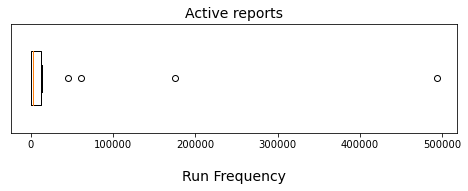

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,2))
plt.boxplot(error_count.values, vert=False, widths=[.5])
plt.title('Active reports', fontsize=14)
plt.xlabel('\nRun Frequency', fontsize=14)
plt.yticks([])
plt.show()

With this boxplot we can see there are 4 outlier reports with much more errors than the others.

Both mean and standard deviation are too high to consider, if we choose one of them as a threshold we would get a dataset with 2 or 3 results. The median seems more useful in this case.

### Generating datasets

There are 2 options for datasets: the top 5 reports with more errors and the reports with errors above the median. We will generate both and save for future analysis.

In [16]:
top_five = error_count.head(5)
top_five

,REPORT_ID_DERIVED
00O0b000006iNwdEAE,493696
00O0b000004AmRrEAK,175527
00O0b000004kTazEAE,60345
00O2R000004AmwmUAC,44593
00O2R000004AmgKUAS,13845


In [17]:
above_median = error_count[error_count['REPORT_ID_DERIVED']>error_count_median]
above_median

,REPORT_ID_DERIVED
00O0b000006iNwdEAE,493696
00O0b000004AmRrEAK,175527
00O0b000004kTazEAE,60345
00O2R000004AmwmUAC,44593
00O2R000004AmgKUAS,13845
00O0b000005yLBGEA2,9144
00O2R000003JCXaUAO,4584
00O0b000004AoOOEA0,3960
00O0b000004kkZKEAY,3150


In [18]:
top_five\
    .to_csv("../../datasets/top_five_problematic_by_errors.csv", index=False)

In [19]:
above_median\
    .to_csv("../../datasets/above_median_problematic_by_errors.csv", index=False)

We can also save the filtered Lightning Error dataset to help with other analysis.

In [20]:
ltng_error_filtered\
    .to_csv("../../datasets/ltng_error_filtered.csv", index=False)